In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

import sys
sys.path.append('/Users/chuanlin/Documents/GitHub/hft-playground')
import hft_play

# Function to convert time strings to datetime objects
def convert_to_datetime(time_str):
    return datetime.strptime(time_str, "%H:%M:%S.%f")

In [2]:
# Load the data
trade_df = pd.read_csv('data/trade.csv')
quote_df = pd.read_csv('data/quote.csv')

In [3]:
# Convert time columns
trade_df['datetime'] = trade_df['time'].apply(convert_to_datetime)
quote_df['datetime'] = quote_df['time'].apply(convert_to_datetime)
trade_df.set_index('datetime', inplace=True)
quote_df.set_index('datetime', inplace=True)

In [4]:
# Aggregate trade data
def vwap(df):
    v = df['volume']
    p = df['price']
    return (v * p).sum() / v.sum() if v.sum()!=0 else np.nan


def twap(df):
    return df['price'].mean()


trade_ohlcv = trade_df.resample('5T').agg({
    'price': ['first', 'max', 'min', 'last'],
    'volume': 'sum',
    'time': 'count'
})
trade_ohlcv.columns = ['open', 'high', 'low', 'close', 'volume', 'n_trd']
trade_vwap = trade_df.resample('5T').apply(vwap).rename('vwap')
trade_twap = trade_df.resample('5T').apply(twap).rename('twap')
trade_agg = pd.concat([trade_ohlcv, trade_vwap, trade_twap], axis=1)

In [5]:
# Aggregate quote data
quote_agg = quote_df.resample('5T').agg({
    'bid_price': 'last', 'ask_price': 'last',
    'bid_size': 'last', 'ask_size': 'last',
    'time': 'count'
}).rename(columns={'time': 'n_quo'})

In [6]:
# Calculate liquidity flow data

# Shift the quote dataframe by one period forward to get the previous quote
quote_shifted = quote_df.shift(1)

# Calculate liquidity metrics using the shifted data
# Liquidity addition is the increase in bid/ask size
liquidity_add_bid = (quote_df['bid_size'] - quote_shifted['bid_size']).clip(lower=0)
liquidity_add_ask = (quote_df['ask_size'] - quote_shifted['ask_size']).clip(lower=0)

# Liquidity taken is the decrease in bid/ask size
liquidity_taken_bid = (quote_shifted['bid_size'] - quote_df['bid_size']).clip(lower=0)
liquidity_taken_ask = (quote_shifted['ask_size'] - quote_df['ask_size']).clip(lower=0)

# Assigning liquidity metrics to the quote dataframe
quote_df['liquidity_add_bid'] = liquidity_add_bid
quote_df['liquidity_add_ask'] = liquidity_add_ask
quote_df['liquidity_taken_bid'] = liquidity_taken_bid
quote_df['liquidity_taken_ask'] = liquidity_taken_ask

# Aggregate liquidity metrics into the 5-minute bins
liquidity_agg = quote_df.resample('5T').agg({
    'liquidity_add_bid': 'sum',
    'liquidity_add_ask': 'sum',
    'liquidity_taken_bid': 'sum',
    'liquidity_taken_ask': 'sum'
})

# for this liquidity taken, actially conbined 2 parts, cancel and trade.

In [7]:
df = quote_df.merge(trade_df, how='outer', on='time')
df['lst_bid_price'] = df['bid_price'].shift(1).ffill()
df['lst_ask_price'] = df['ask_price'].shift(1).ffill()

# map trade sign
df['active_buy'] = np.where(df['price'] >= df['lst_ask_price'], df['volume'], 0)
df['active_sell'] = np.where(df['price'] <= df['lst_bid_price'], df['volume'], 0)

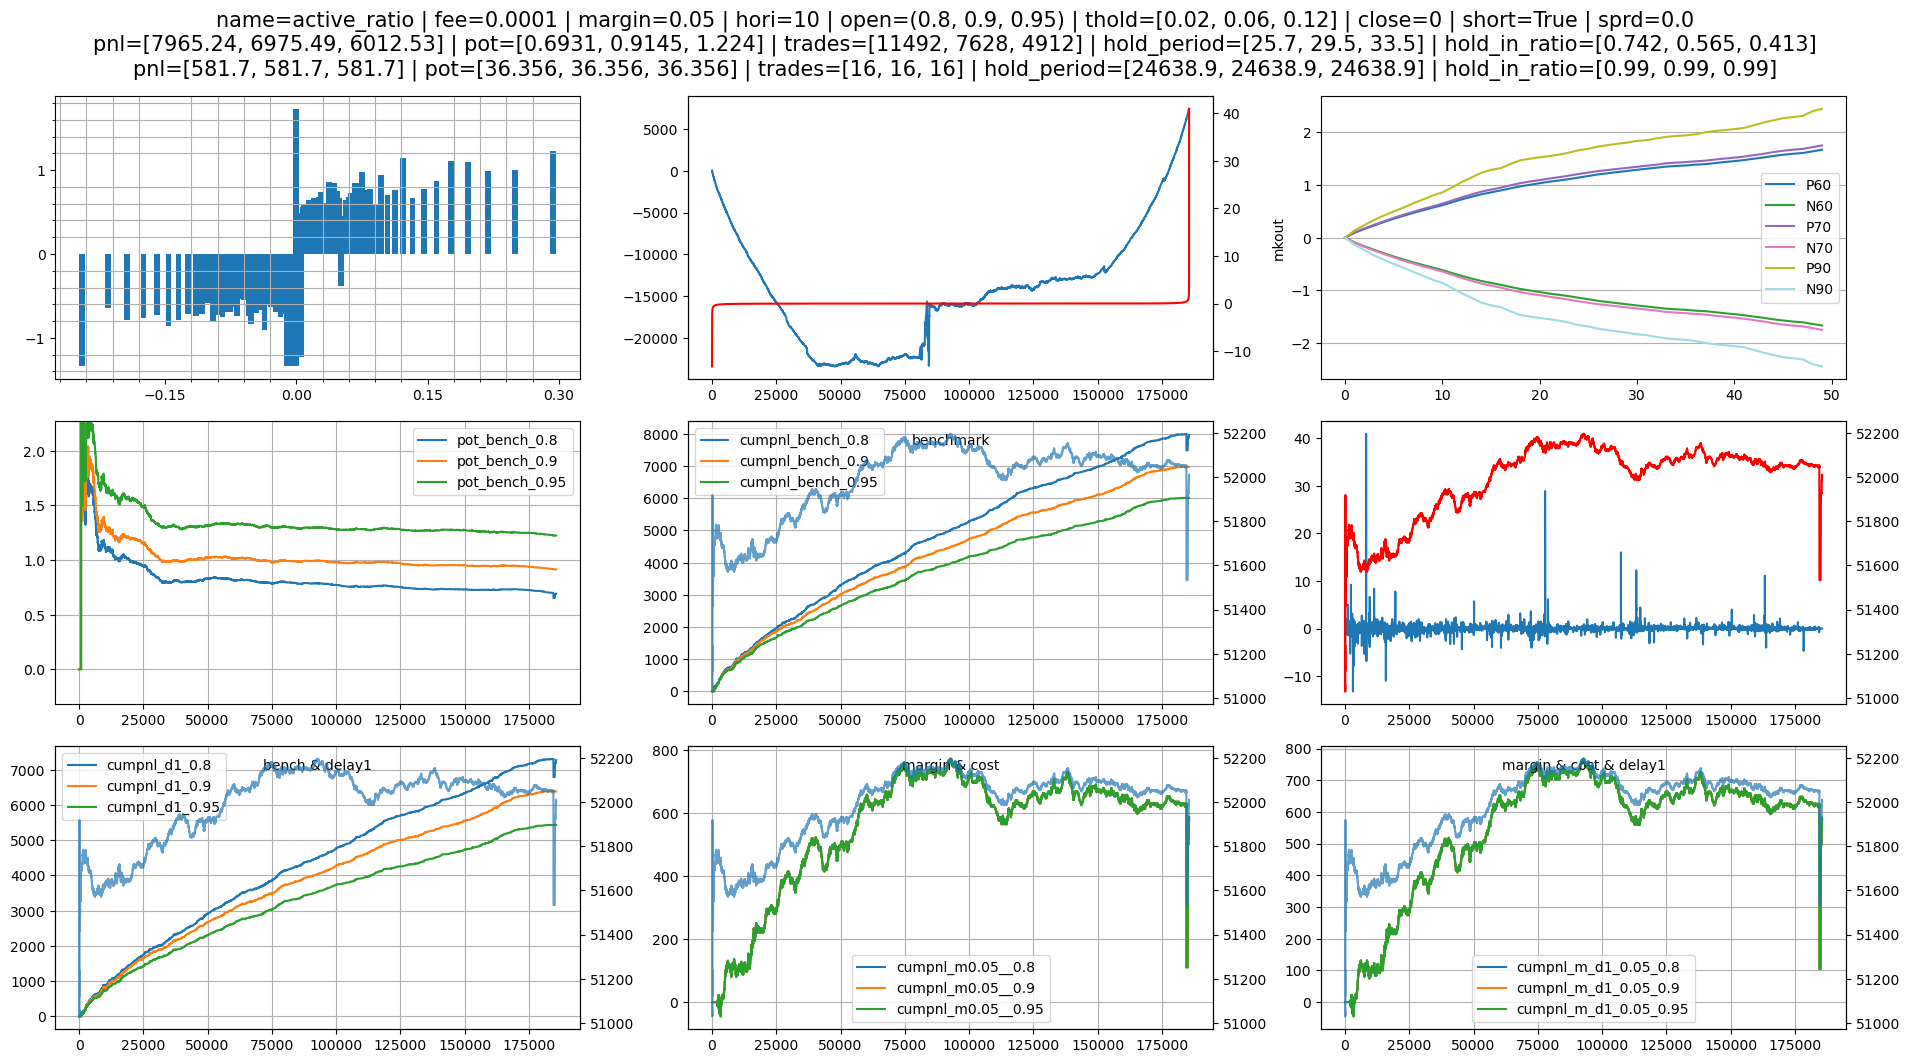

In [8]:
# brifly check the factor efficacy

df['mid_price'] = (df['bid_price'] + df['ask_price']) / 2
df['logmid'] = np.log(df['mid_price'])
df['avg_bbo_size'] = (df['bid_size'] + df['ask_size']) / 2
df['active_ratio'] = (df['active_buy']-df['active_sell'])/df['avg_bbo_size']
hft_play.ca(df['logmid']*1e4, df['active_ratio'])

# like all hft factor, this ratio is stable, but small contribution, like 1.2 bp, which would be higher after aggregation.

In [9]:
df['spread'] = df['ask_price'] - df['bid_price']
(df.spread / df.mid_price).mean() * 1e4

# but the spread is like 7.5 bp

7.535533549619037

In [10]:
# agg to 5 min
df['datetime'] = df['time'].apply(convert_to_datetime)
df.set_index('datetime', inplace=True)
active_trade_agg = df.resample('5T').agg({
    'active_buy': 'sum',
    'active_sell': 'sum',
    'time': 'last',
})

In [11]:
# Combine all data
df_feat = pd.concat([trade_agg, quote_agg, liquidity_agg, active_trade_agg], axis=1)
df_feat.to_csv('output/df_feat.csv')

In [12]:
df_feat

,open,high,low,close,volume,n_trd,vwap,twap,bid_price,ask_price,bid_size,ask_size,n_quo,liquidity_add_bid,liquidity_add_ask,liquidity_taken_bid,liquidity_taken_ask,active_buy,active_sell,time
datetime,,,,,,,,,,,,,,,,,,,,
1900-01-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.8,179.8,126900.0,139800.0,173,144100.0,168900.0,17300.0,29600.0,0.0,0.0,09:04:55.842
1900-01-01 09:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.1,174.1,152700.0,143400.0,71,40500.0,13800.0,14700.0,10200.0,0.0,0.0,09:09:58.558
1900-01-01 09:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173.3,173.3,234600.0,242500.0,236,293700.0,182800.0,211800.0,83700.0,0.0,0.0,09:14:58.534
1900-01-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173.8,173.8,581300.0,581300.0,213,606800.0,338800.0,260100.0,0.0,0.0,0.0,09:19:59.983
1900-01-01 09:20:00,175.20,175.2,175.2,175.2,613500.0,319.0,175.200000,175.200000,175.2,176.0,500.0,300.0,79,179300.0,32200.0,760100.0,613200.0,100.0,613500.0,09:20:43.207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-01-01 15:45:00,181.95,182.7,181.0,182.6,697348.0,1322.0,182.212546,182.240885,182.6,182.7,16700.0,16800.0,1914,984800.0,641000.0,997800.0,652700.0,768632.0,359816.0,15:49:59.995
1900-01-01 15:50:00,182.60,182.7,182.1,182.3,645100.0,1553.0,182.388738,182.388506,182.2,182.3,9500.0,5700.0,2481,1421800.0,880600.0,1429000.0,891700.0,333100.0,689800.0,15:54:59.006
1900-01-01 15:55:00,182.20,182.4,182.0,182.1,465100.0,1293.0,182.188110,182.199149,182.0,182.1,33200.0,5400.0,2378,1150700.0,590800.0,1127000.0,591100.0,213200.0,456400.0,15:59:58.074
